# PSD Classification

- Prepare Xy
    - include only experience rows in X
- fit a simple svm classifier
- model based feature selection
- feature scaling
- cross validated score
- permutation test plot
- dummy classifier for chance level
- arbitrary scores (accuracy and auc)
- permutation importance plot
- SHAP values

In [23]:
import pandas as pd
import numpy as np

DATA = pd.read_csv('data/classification_dataset.csv', index_col=0)
DATA = DATA.query('not condition.str.contains("baseline")', engine='python')

# Xy
X = DATA.drop(columns=['hypnosis_depth', 'bids_id', 'condition', 'procedure', 'description', 'session'])
hypnosis_depth_median = DATA['hypnosis_depth'].median()
y = DATA['hypnosis_depth'].apply(lambda x: 'low' if x <= hypnosis_depth_median  else 'high')

In [72]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('select', SelectFromModel(SVC(kernel='linear'))),
    ('svm', SVC(kernel='linear', probability=True)),
    # ('dummy', DummyClassifier(strategy='uniform'))
])

scores = []
for train, test in tqdm(cv.split(X, y), total=cv.get_n_splits()):
    pipe.fit(X.iloc[train], y.iloc[train])
    # score = pipe.score(X.iloc[test], y.iloc[test])
    y_pred_prop = pipe.predict_proba(X.iloc[test])[:, 1]
    score = roc_auc_score(y.iloc[test], y_pred_prop)
    scores.append(score)

print(np.mean(scores), np.std(scores))


100%|██████████| 50/50 [00:03<00:00, 16.50it/s]

0.7025026006868113 0.048031623646514816


In [73]:
# permutation test
from sklearn.model_selection import permutation_test_score

obs_score, perm_socres, p_value = permutation_test_score(
    pipe, X, y, cv=cv, scoring='roc_auc', n_permutations=100, n_jobs=-1, verbose=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


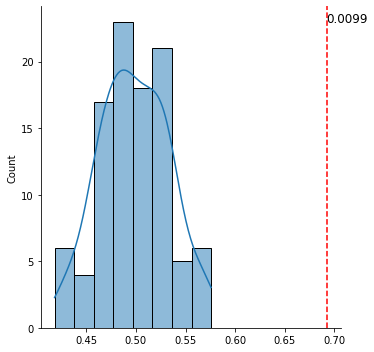

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# TODO: improve visualization
sns.displot(perm_socres, kde=True)
plt.axvline(obs_score, color='r', linestyle='--')
plt.annotate(f'{p_value:.4f}', xy=(0.95, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance

importances = []
for train, test in tqdm(cv.split(X, y), total=cv.get_n_splits()):
    pipe.fit(X.iloc[train], y.iloc[train])
    perm_imp_results = permutation_importance(
        pipe, X, y, scoring='roc_auc', n_repeats=2, n_jobs=-1)
    importances.append(perm_imp_results['importances'])

importances

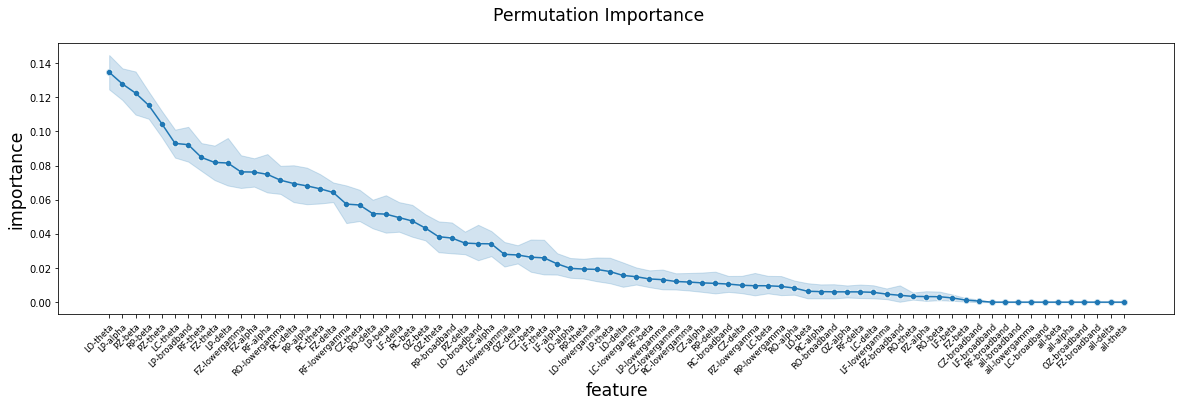

In [123]:
imp_df = pd.DataFrame(np.hstack(importances), index=X.columns)
imp_df.reset_index(inplace=True)
imp_df = imp_df.melt(id_vars=['index'])
imp_df.rename(columns={'index': 'feature', 'value': 'importance', 'variable': 'repetition'}, inplace=True)
imp_df['mean_importance'] = imp_df.groupby('feature')['importance'].transform('mean')
imp_df.sort_values(by='mean_importance', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(20, 5))
# sns.barplot(x='importance', y='feature', data=imp_df, orient='h', ax=ax, )
sns.lineplot(x='feature', y='importance', data=imp_df, ax=ax, ci=95)
sns.scatterplot(x='feature', y='mean_importance', data=imp_df, ax=ax)
plt.xticks(rotation=45, fontsize='small', rotation_mode='anchor', ha='right')
plt.xlabel('feature', fontsize='xx-large')
plt.ylabel('importance', fontsize='xx-large')
plt.suptitle('Permutation Importance', fontsize='xx-large')
plt.show()